# Iterating, Tuning Hyper-Parameters and Testing Advanced Features

## Key Revisions to the Strategic Framework

1. Feature Engineering Becomes a Cycle of Creation and Pruning

2. Robust, API-Ready Validation is Non-Negotiable.

3. Targeted, Metric-Driven Hyperparameter Tuning.

4. Modular, Interpretable Code.

## Setup and Load Data

In [1]:
#### TEMPORARY
import sys
sys.path.append('/home/bac/code/kaggle/kaggle-cmi-detect-behavior/')

In [2]:
import pandas as pd
import numpy as np
import os
import catboost as cat
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# --- Pathing and Experiment Tracking Setup ---
from src.tracking import ExperimentTracker
from src.config import DATA_PATH, PROJECT_PATH, USE_WANDB, WANDB_PROJECT, WANDB_ENTITY

tracker = ExperimentTracker(
    project_path=os.path.expanduser(PROJECT_PATH),
    use_wandb=USE_WANDB,
    wandb_project_name=WANDB_PROJECT,
    wandb_entity=WANDB_ENTITY
)

SEED = 42

In [3]:
# Load the raw data and create helper maps
train_sensor = pd.read_csv(os.path.join(os.path.expanduser(DATA_PATH), 'train.csv'))
train_demos = pd.read_csv(os.path.join(os.path.expanduser(DATA_PATH), 'train_demographics.csv'))
train_df = pd.merge(train_sensor, train_demos, on='subject', how='left')
metadata = train_df[['gesture', 'sequence_type']].drop_duplicates()
gesture_to_seq_type_map = metadata.set_index('gesture')['sequence_type'].to_dict()
gesture_map = {label: i for i, label in enumerate(metadata['gesture'].unique())}
inv_gesture_map = {i: label for label, i in gesture_map.items()}

## Pipeline Components

Major components which have been used to train the model baseline thusfar will be encapsulated in modular code.

1. Wave 4 feature generation
2. Competition metric
3. Model Training

**`NOTE` the model generates inconsistencies in the code following a strategic review. These errors need to be reviewed!! At present, these were spotted in the `create_wave4_features()` function.**

```python
def create_wave4_features(df):
    """
    Creates Wave-4 features: Adds demographic features to Wave 3a-PCA
    feature set.
    """
    
    ...
    for col in base_cols_to_agg + derived_cols_to_agg + tof_derived_cols_to_agg:
        aggs[col] = ['mean', 'std', 'min', 'max'] # FLAG

    phase_agg_df = df_feat.groupby(['sequence_id', 'phase']).agg(aggs)
    phase_agg_df.columns = ['_'.join(col).strip() for col in phase_agg_df.columns.values]
    phase_agg_df_unstacked = phase_agg_df.unstack(level='phase') # FLAG FILLNA
    phase_agg_df_unstacked.columns = ['_'.join(col).strip() for col in phase_agg_df_unstacked.columns.values]
    
    meta_df = df.groupby('sequence_id').first()
    final_df = pd.concat([meta_df[['subject', 'gesture'] + list(train_demos.columns[1:])], phase_agg_df_unstacked], axis=1).reset_index()
    
    # Create interaction features
    key_sensor_features = [
        'acc_mag_mean_Gesture', 'acc_mag_std_Gesture', 'jerk_mean_Gesture',
        'jerk_std_Gesture', 'tof_pca_0_mean_Gesture', 'tofl_invalid_pct_mean_Gesture'
    ]
    demographic_features = ['age', 'height_cm', 'shoulder_to_wrist_cm'] # flag
    
    for sensor_feat in key_sensor_features:
        for demo_feat in demographic_features:
            if sensor_feat in final_df.columns and demo_feat in final_df.columns:
                # Interaction by division (normalizing sensor reading by demographic)
                final_df[f'{sensor_feat}_div_{demo_feat}'] = final_df[sensor_feat] / (final_df[demo_feat] + 1e-6)
                # Ineraction by multiplication
                final_df[f'{sensor_feat}_mul_{demo_feat}'] = final_df[sensor_feat] * final_df[demo_feat]
    
    #final_df.drop(columns='subject', inplace=True)
    final_df['gesture_encoded'] = final_df['gesture'].map(gesture_map)
    
    print(f"Feature engineering complete. Shape of features: {final_df.shape}")
    return final_df
```

In [4]:
def create_wave4n_features(df):
    """
    Creates Wave-4 features: Adds demographic features to Wave 3a-PCA
    feature set. With slight modifications below.
    """
    print("Starting Wave 4 (Interaction) Feature Engineering...")
    df_feat = df.copy()
    df_feat['acc_mag'] = np.sqrt(df_feat['acc_x']**2 + df_feat['acc_y']**2 + df_feat['acc_z']**2)
    df_feat['rot_mag'] = np.sqrt(df_feat['rot_w']**2 + df_feat['rot_x']**2 + df_feat['rot_y']**2 + df_feat['rot_z']**2)
    df_feat['jerk'] = df_feat.groupby('sequence_id')['acc_mag'].diff().fillna(0)
    for i in range(1, 5): 
        df_feat[f'thm_grad_{i}_{i+1}'] = df_feat[f'thm_{i}'] - df_feat[f'thm_{i+1}']
    
    tof_cols = [f'tof_{s}_v{p}' for s in range(1, 6) for p in range(64)]
    tof_data = df_feat[tof_cols].replace(-1, np.nan)
    df_feat['tof_invalid_pct'] = tof_data.isna().mean(axis=1)
    
    pca = PCA(n_components=10, random_state=SEED) 
    tof_pca_features = pca.fit_transform(tof_data.fillna(0))
    for i in range(10): 
        df_feat[f'tof_pca_{i}'] = tof_pca_features[:, i]
        
    base_cols_to_agg = [col for col in df.columns if 'acc_' in col or 'rot_' in col or 'thm_' in col]
    derived_cols_to_agg = [col for col in df_feat.columns if 'mag' in col or 'jerk' in col or 'grad' in col]
    tof_derived_cols_to_agg = ['tof_invalid_pct'] + [f'tof_pca_{i}' for i in range(10)]
    aggs = {}
    for col in base_cols_to_agg + derived_cols_to_agg: 
        aggs[col] = ['mean', 'std', 'min', 'max', 'skew'] # FLAG
    for col in tof_derived_cols_to_agg:
        aggs[col] = ['mean', 'std', 'min', 'max'] # FLAG
        
    phase_agg_df = df_feat.groupby(['sequence_id', 'phase']).agg(aggs)
    phase_agg_df.columns = ['_'.join(col).strip() for col in phase_agg_df.columns.values]
    phase_agg_df_unstacked = phase_agg_df.unstack(level='phase').fillna(0) # FLAG
    phase_agg_df_unstacked.columns = ['_'.join(col).strip() for col in phase_agg_df_unstacked.columns.values]
    
    meta_df = df.groupby('sequence_id').first()
    final_df = pd.concat([meta_df[['gesture'] + list(train_demos.columns)], phase_agg_df_unstacked], axis=1).reset_index()
    
    key_sensor_features = ['acc_mag_mean_Gesture', 'acc_mag_std_Gesture', 'jerk_mean_Gesture', 
                           'jerk_std_Gesture', 'tof_pca_0_mean_Gesture', 'tof_invalid_pct_mean_Gesture']
    demographic_features = ['age', 'height_cm', 'shoulder_to_wrist_cm', 'sex', 'elbow_to_wrist_cm'] # FLAG
    for sensor_feat in key_sensor_features:
        for demo_feat in demographic_features:
            if sensor_feat in final_df.columns and demo_feat in final_df.columns:
                final_df[f'{sensor_feat}_div_{demo_feat}'] = final_df[sensor_feat] / (final_df[demo_feat] + 1e-6)
                final_df[f'{sensor_feat}_mul_{demo_feat}'] = final_df[sensor_feat] * final_df[demo_feat]
                
    final_df['gesture_encoded'] = final_df['gesture'].map(gesture_map)
    print(f"Feature engineering complete. Shape of features: {final_df.shape}")
    
    return final_df

In [5]:
# Modified version to handle permutation importance calculations

# --- The Final, Robust Scorer Factory ---
def create_competition_scorer(inv_map, seq_type_map):
    """
    This factory function creates a robust, self-contained scorer
    that can handle both predicted probabilities (2D) and predicted labels (1D).
    """
    
    def competition_f1_score_internal(y_true_encoded, y_pred, **kwargs):
        """
        The actual scoring logic. It checks the dimension of y_pred to
        determine if it needs to perform an argmax operation.
        """
        # --- ROBUSTNESS FIX ---
        if y_pred.ndim == 2:
            # Input is probabilities, find the most likely class
            y_pred_encoded = np.argmax(y_pred, axis=1)
        else:
            # Input is already encoded labels
            y_pred_encoded = y_pred

        # Map integer-encoded labels back to their string representations
        y_true_str = pd.Series(y_true_encoded).map(inv_map)
        y_pred_str = pd.Series(y_pred_encoded).map(inv_map)
        
        # --- The rest of the scoring logic is the same ---
        y_true_binary = y_true_str.map(seq_type_map)
        y_pred_binary = y_pred_str.map(seq_type_map)
        binary_f1 = f1_score(y_true_binary, y_pred_binary, pos_label='Target', average='binary', zero_division=0)

        def collapse_non_target(gesture):
            return 'non_target' if seq_type_map.get(gesture) == 'Non-Target' else gesture
            
        y_true_collapsed = y_true_str.apply(collapse_non_target)
        y_pred_collapsed = y_pred_str.apply(collapse_non_target)
        macro_f1 = f1_score(y_true_collapsed, y_pred_collapsed, average='macro', zero_division=0)
        
        return (binary_f1 + macro_f1) / 2

    return competition_f1_score_internal

In [6]:
def get_trained_model(X_train, y_train, X_val, y_val, params): # 
    """Trains a CatBoost model and returns the trained object."""
    model = cat.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100)
    return model


def plot_feature_importance(model, feature_names, top_n=50):
    """Plots feature importance from a trained CatBoost model"""
    imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.get_feature_importance()
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, top_n / 2))
    sns.barplot(x='importance', y='feature', data=imp_df)
    plt.title(f'Top {top_n} Features (CatBoost Built-in Importance)')
    plt.tight_layout()
    plt.show()
    return imp_df

def calculate_permutation_importance(model, X_val, y_val, scorer, top_n=50):
    """Calculates and plots permutation importance."""
    print("Calculating Permutation Importance...")
    
    # We will now use n_jobs=1 by default to guarantee stability.
    result = permutation_importance(
        model, X_val, y_val, n_repeats=5, random_state=SEED, n_jobs=1, scoring=scorer
    )
    
    perm_importance_df = pd.DataFrame({
        'feature': X_val.columns,
        'importance_mean': result.importances_mean,
        'importance_std': result.importances_std,
    }).sort_values('importance_mean', ascending=False)
    
    positive_importance_df = perm_importance_df[perm_importance_df['importance_mean'] > 0].head(top_n)

    if positive_importance_df.empty:
        print("\n!!! No features with positive permutation importance were found.")
        return perm_importance_df

    print("\nTop 10 Permutation Importances:\n", positive_importance_df.head(10))
    
    plt.figure(figsize=(10, max(10, top_n / 2)))
    plt.barh(
        positive_importance_df['feature'],
        positive_importance_df['importance_mean'],
        xerr=positive_importance_df['importance_std'],
        align='center'
    )
    plt.title(f'Top {top_n} Features with Positive Permutation Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return perm_importance_df

In [7]:
features_df = create_wave4n_features(train_df)

Starting Wave 4 (Interaction) Feature Engineering...
Feature engineering complete. Shape of features: (8151, 349)


In [8]:
# --- Model Parameters ---
params = {
    'iterations': 1000, 'learning_rate': 0.05, 'depth': 6,
    'loss_function': 'MultiClass', 'eval_metric': 'MultiClass',
    'random_seed': SEED, 'verbose': 0
}

# --- Prepare data for CV ---
X = features_df.drop(columns=['sequence_id', 'subject', 'gesture', 'gesture_encoded'])
y = features_df['gesture_encoded']
#groups = features_df['subject']

## Training Run for Feature Wave 4n

In [ ]:
# Setup training run and prep data
FEATURE_WAVE = "Wave 4n"
MODEL_NAME = "Catboost"
EXPERIMENT_NAME = f"{FEATURE_WAVE}-{MODEL_NAME}-CPU"
N_SPLITS = 5

In [15]:
# Train and evaluate.
fold_scores = []
cv = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
    print(f"--- Fold {fold+1}/{N_SPLITS} ---")
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = cat.CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100)
    
    # Predict on validation set
    val_preds_proba = model.predict_proba(X_val)
    
    # Evaluate fold performance using the official metric
    fold_score = average_f1_score(y_val, val_preds_proba)
    fold_scores.append(fold_score)
    print(f"Fold {fold+1} Competition F1 Score: {fold_score:.5f}")

# --- Final Score and Logging ---
mean_cv_score = np.mean(fold_scores)
print(f"\n--- CV Summary for {MODEL_NAME} ---")
print(f"Mean Competition F1 Score: {mean_cv_score:.5f}")
print(f"Std Dev: {np.std(fold_scores):.5f}\n")

tracker.log_experiment(
    experiment_name=EXPERIMENT_NAME, model_name=MODEL_NAME, feature_wave=FEATURE_WAVE,
    cv_score=mean_cv_score, params=params,
    notes="Evaluating Wave-4n baseline - Wave 3a+interaction features + flagged changes"
)

--- Fold 1/5 ---
Fold 1 Competition F1 Score: 0.83732
--- Fold 2/5 ---
Fold 2 Competition F1 Score: 0.78276
--- Fold 3/5 ---
Fold 3 Competition F1 Score: 0.80444
--- Fold 4/5 ---
Fold 4 Competition F1 Score: 0.78602
--- Fold 5/5 ---
Fold 5 Competition F1 Score: 0.79796

--- CV Summary for Catboost ---
Mean Competition F1 Score: 0.80170
Std Dev: 0.01947

Experiment 'Wave 4n-Catboost-CPU' logged to /home/bac/code/kaggle/kaggle-cmi-detect-behavior/experiment_log.csv


wandb: Currently logged in as: b-a-chaudhry (b-a-chaudhry-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


cv_score,▁
cv_score,0.8017
feature_wave,Wave 4n
model_name,Catboost


Experiment 'Wave 4n-Catboost-CPU' logged to W&B


## Feature and Permutation Importance for Pruning

In [9]:
# Training on one representative fold for feature analysis
cv_split = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED).split(X, y, groups=features_df['sequence_id'])
train_idx, val_idx = next(cv_split)

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

# Train model and get importances
print("Training a single model on fold 0 to analyze feature importance...")
model = get_trained_model(X_train, y_train, X_val, y_val, params)

Training a single model on fold 0 to analyze feature importance...


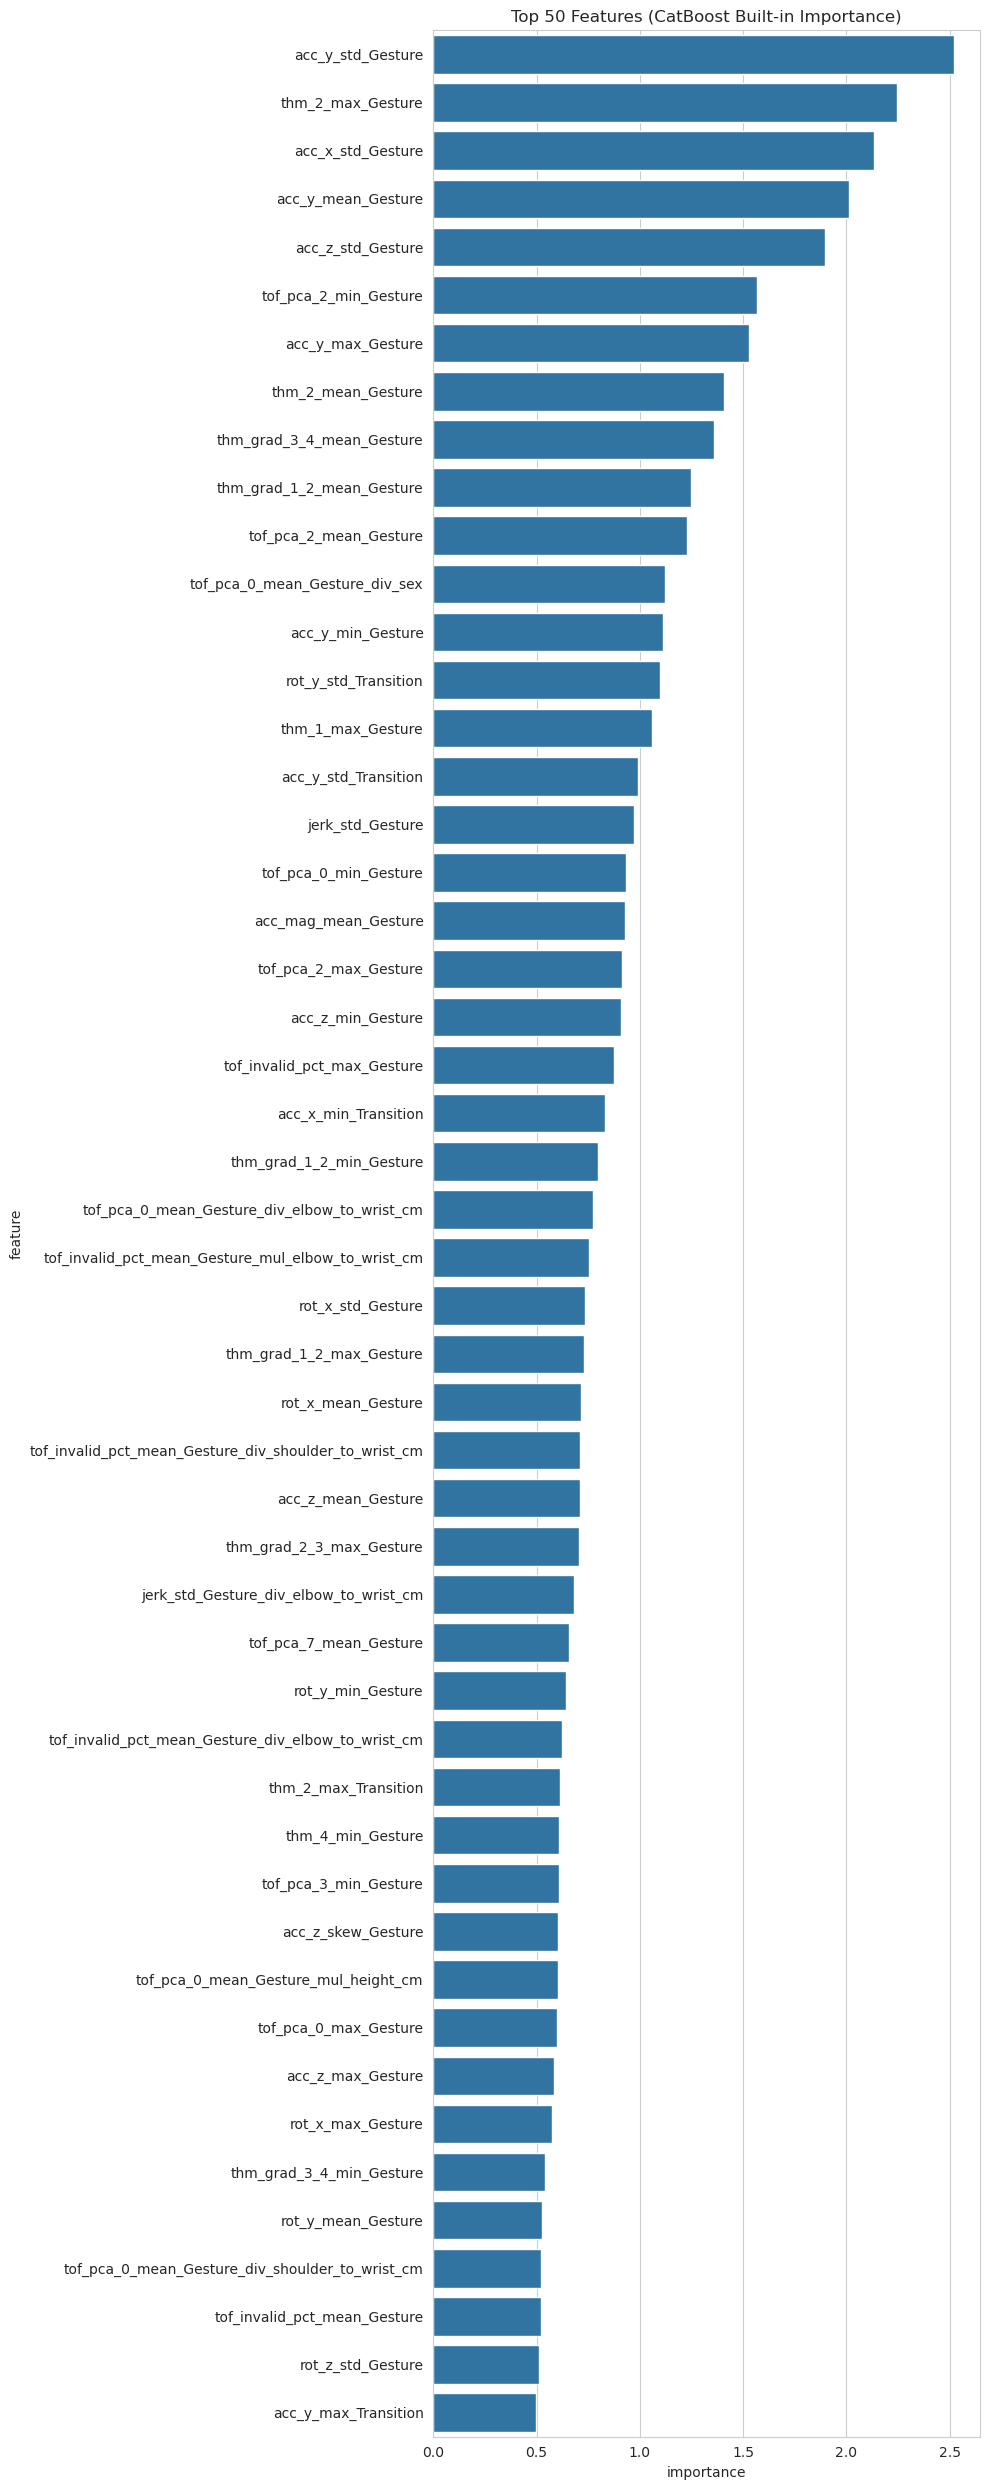

In [10]:
feat_importance = plot_feature_importance(model, X.columns)

In [11]:
# --- Create the scorer function ---
competition_scorer_func = create_competition_scorer(inv_gesture_map, gesture_to_seq_type_map)

# --- Run Permutation Importance on CatBoost ---
# Use needs_proba=False, as we've seen this can be unreliable. Our function handles both cases.
scorer_for_perm_importance = make_scorer(competition_scorer_func, needs_proba=False)

perm_importance_df = calculate_permutation_importance(
    model, 
    X_val, 
    y_val,
    scorer=scorer_for_perm_importance
)

Calculating Permutation Importance...

!!! No features with positive permutation importance were found.


## Solving the Permutation Importance Issue With Custom Workarounds

### Test to examine Permutation Importance Problem.

--- Diagnostic Step: Training a LightGBM model ---
LightGBM model trained.

--- Running Permutation Importance on LightGBM ---
Calculating Permutation Importance...
DEBUG: Scorer received y_pred of type: <class 'numpy.ndarray'>, shape: (1631,)
DEBUG: First 5 elements of 1D y_pred: [ 0  3  7 10  4]
DEBUG: Scorer received y_pred of type: <class 'numpy.ndarray'>, shape: (1631,)
DEBUG: First 5 elements of 1D y_pred: [ 0  3  7 10  4]
DEBUG: Scorer received y_pred of type: <class 'numpy.ndarray'>, shape: (1631,)
DEBUG: First 5 elements of 1D y_pred: [ 0  3  7 10  4]
DEBUG: Scorer received y_pred of type: <class 'numpy.ndarray'>, shape: (1631,)
DEBUG: First 5 elements of 1D y_pred: [ 0  3  7 10  4]
DEBUG: Scorer received y_pred of type: <class 'numpy.ndarray'>, shape: (1631,)
DEBUG: First 5 elements of 1D y_pred: [ 0  3  7 10  4]
DEBUG: Scorer received y_pred of type: <class 'numpy.ndarray'>, shape: (1631,)
DEBUG: First 5 elements of 1D y_pred: [ 0  3  7 10  4]
DEBUG: Scorer received y_pred o

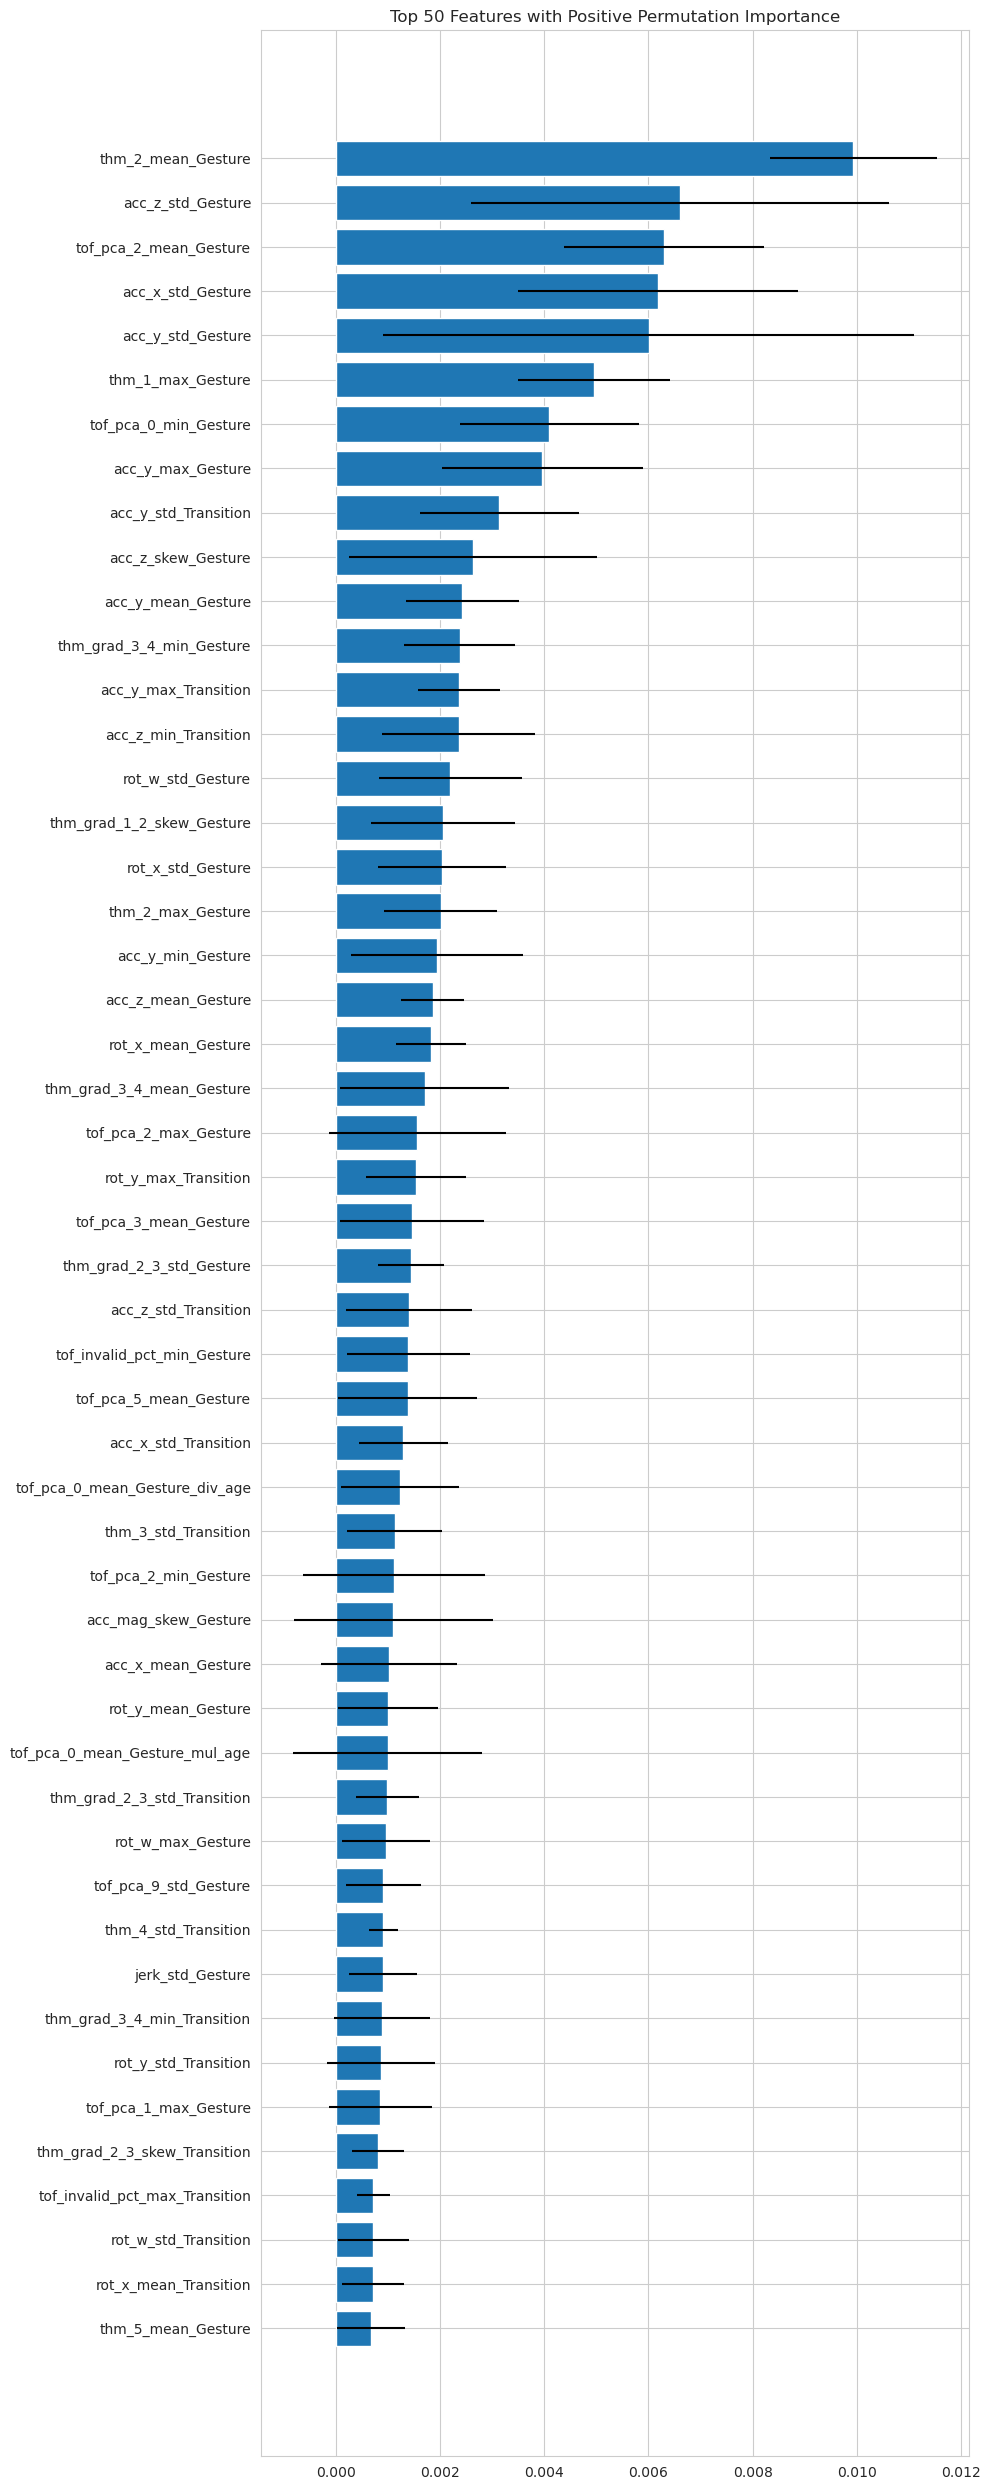

In [33]:
import lightgbm as lgb

# --- 1. Train a LightGBM model on the same data fold ---
print("--- Diagnostic Step: Training a LightGBM model ---")
lgbm_params = {
    'objective': 'multiclass',
    'num_class': y.nunique(),
    'metric': 'multi_logloss',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'n_jobs': -1,
    'seed': SEED
}

lgbm_model = lgb.LGBMClassifier(**lgbm_params)
lgbm_model.fit(X_train, y_train,
             eval_set=[(X_val, y_val)],
             callbacks=[lgb.early_stopping(100, verbose=False)])

print("LightGBM model trained.")

# --- 2. Create the scorer (using the same factory) ---
# This ensures we are using the identical scoring logic
competition_scorer_func = create_competition_scorer(inv_gesture_map, gesture_to_seq_type_map)
final_scorer = make_scorer(competition_scorer_func, needs_proba=True)

# --- 3. Run Permutation Importance on the LightGBM model ---
print("\n--- Running Permutation Importance on LightGBM ---")

# We are using the exact same function and scorer as before
perm_importance_lgbm_df = calculate_permutation_importance(
    lgbm_model,
    X_val,
    y_val,
    scorer=final_scorer
)

### Bypassing `sklearn.inspection.permutation_importance`

In [12]:
# Get the most important feature from the CatBoost Feature Importance Plot
top_feature = feat_importance['feature'].iloc[0]

# Baseline predictions on the original unshuffled data
baseline_predictions = model.predict(X_val)

# Copy of validation to shuffle
X_val_shuffled = X_val.copy()

# Shuffle only the single most important column and assign back
shuffled_column = X_val_shuffled[top_feature].sample(frac=1, random_state=SEED).values
X_val_shuffled[top_feature] = shuffled_column

# Get new predictions with the shuffled column
shuffled_predictions = model.predict(X_val_shuffled)

# Compare the predictions
are_predictions_identical = np.array_equal(baseline_predictions, shuffled_predictions)

print("Results")

if are_predictions_identical:
    print("!!! TEST FAILED: The model's predictions DID NOT CHANGE after shuffling the most important feature.")
    print("This confirms the root cause: The CatBoost model object is invariant to this shuffling.")
    print("This is not a scorer issue, but an issue with the model's prediction behavior in this context.")
else:
    print(">>> TEST PASSED: The model's predictions CHANGED after shuffling.")
    print("This means the permutation is having an effect, and the issue lies elsewhere.")
    
# Check the scores to see the impact
scorer_func = create_competition_scorer(inv_gesture_map, gesture_to_seq_type_map)
baseline_score = scorer_func(y_val, model.predict_proba(X_val))
shuffled_score = scorer_func(y_val, model.predict_proba(X_val_shuffled))

print(f"\nBaseline Score on original data: {baseline_score:.5f}")
print(f"Score on data with one shuffled column: {shuffled_score:.5f}")
print(f"Score Difference (Importance): {baseline_score - shuffled_score:.5f}")


Results
>>> TEST PASSED: The model's predictions CHANGED after shuffling.
This means the permutation is having an effect, and the issue lies elsewhere.

Baseline Score on original data: 0.82151
Score on data with one shuffled column: 0.81193
Score Difference (Importance): 0.00958


### SOLUTION: Custom Function for Permutation Importance Calculations

The manual test proved the following:

- The CatBoost Model is Working: Manually shuffling a column while keeping the data as a pandas DataFrame and passing it to model.predict() changed the predictions, and the score dropped. This is correct behavior.

- The Scorer is Working: THe custom scorer function correctly identified the drop in performance when the predictions changed.

- The Root Cause: The only difference between the successful manual test and the failing automated function is what happens to the data inside the permutation_importance function. Internally, permutation_importance converts the input pandas DataFrame (X_val) into a NumPy array to perform its shuffling operations. This conversion strips the feature names.

- The CatBoost model was trained on a DataFrame with named features. When it is later fed a nameless NumPy array for prediction, it appears to behave differently and, in this specific context, becomes insensitive to the shuffling of a single column, causing it to return the same predictions and thus a zero importance score.

Replacing the packaged function with a custom function.

In [13]:
def custom_permutation_importance(model, X_val, y_val, scorer, top_n=50, n_repeats=5):
    """
    A custom implementation of permutation importance that operates directly on
    pandas DataFrames to avoid issues with scikit-learn's internal type casting.
    """
    print("Calculating Permutation Importance using custom implementation...")
    
    # Calculate baseline score on the original data
    baseline_predictions = model.predict_proba(X_val)
    baseline_score = scorer(y_val, baseline_predictions)
    print(f"Baseline score: {baseline_score:.5f}")
    
    importances = []
    
    for col in X_val.columns:
        original_col = X_val[col].copy()
        col_scores = []
        
        for r in range(n_repeats):
            # Shuffle a single column
            X_val[col] = np.random.RandomState(r).permutation(original_col)
            
            # Get new score
            permuted_predictions = model.predict_proba(X_val)
            permuted_score = scorer(y_val, permuted_predictions)
            col_scores.append(permuted_score)
            
        # Restore the original column
        X_val[col] = original_col
        
        # Calculate importance as the drop in score
        importance = baseline_score - np.mean(col_scores)
        importances.append(importance)
        
    # Create and Plot the Results 
    perm_importance_df = pd.DataFrame({
        'feature': X_val.columns,
        'importance_mean': importances,
    }).sort_values('importance_mean', ascending=False)
    
    positive_importance_df = perm_importance_df[perm_importance_df['importance_mean'] > 0].head(top_n)
    
    if positive_importance_df.empty:
        print("\n No features with positive permutation importance were found!!!")
        return perm_importance_df
    
    print("\n Top 10 permutation Importances:\n", positive_importance_df.head(10))
    
    plt.figure(figsize=(10, max(10, top_n / 2)))
    plt.barh(
        positive_importance_df['feature'],
        positive_importance_df['importance_mean']
    )
    plt.title(f'Top {top_n} Features (Custom Permutation Importance)')
    plt.xlabel('Importance (Decrease in F1 Score)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return perm_importance_df

Calculating Permutation Importance using custom implementation...
Baseline score: 0.82151

 Top 10 permutation Importances:
                     feature  importance_mean
29        acc_z_std_Gesture         0.015851
19        acc_y_std_Gesture         0.011536
9         acc_x_std_Gesture         0.007979
225   tof_pca_2_min_Gesture         0.005815
23        acc_y_max_Gesture         0.005061
227   tof_pca_2_max_Gesture         0.004891
221  tof_pca_2_mean_Gesture         0.004564
213  tof_pca_1_mean_Gesture         0.004092
61        rot_y_min_Gesture         0.003764
63        rot_y_max_Gesture         0.003745


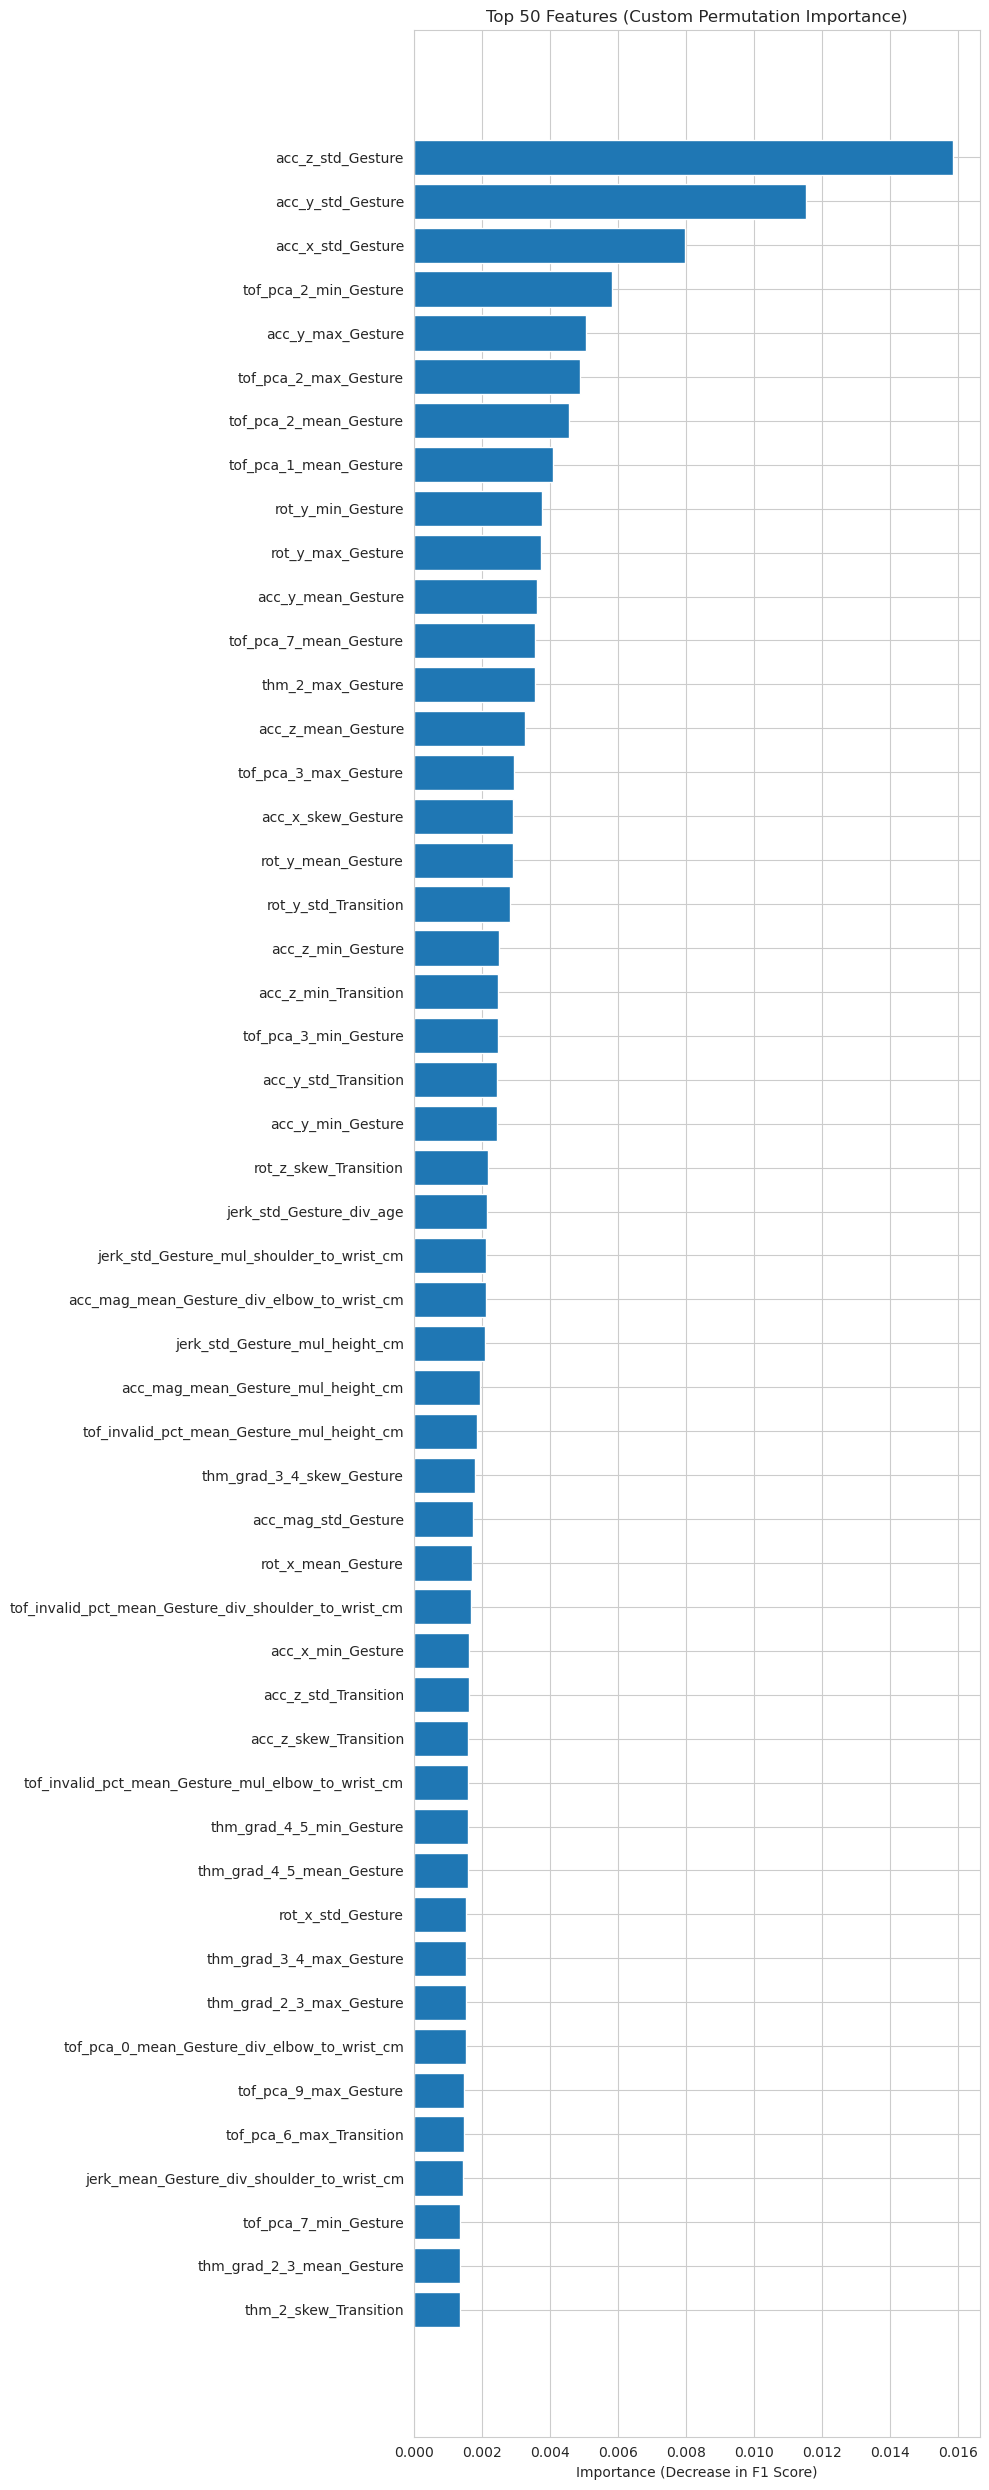

In [14]:
# Recreate scorer function
competition_scorer_func = create_competition_scorer(inv_gesture_map, gesture_to_seq_type_map)

# Run custom permutation importance on CatBoost
perm_importance_df = custom_permutation_importance(
    model,
    X_val,
    y_val,
    scorer=competition_scorer_func
)

**Analysis of Final Permutation Importance Results**

The permutation importance plot is the most reliable measure of feature impact we have. Here’s what it tells us:

    "Gesture" Phase is Dominant: The top features are overwhelmingly from the Gesture phase (e.g., acc_z_std_Gesture, acc_y_std_Gesture). This is a powerful confirmation of our phase-specific feature engineering strategy. It proves that the model learns the most from what happens during the actual gesture itself, not the transitions.

    Variance is a Key Signal: The top three features are all the standard deviation (std) of the accelerometer axes. This makes perfect physical sense: a higher standard deviation means more erratic, high-energy movement, which is a key differentiator between gestures and being still.

    ToF PCA Features are Valuable: Several tof_pca features appear in the top 10 (e.g., tof_pca_2_min_Gesture). This validates our dimensionality reduction strategy and proves that the ToF sensors are contributing significantly to the model's predictive power.

    Actionable Insights for Pruning: We now have a clear, data-driven ranking of our features. We can confidently prune the feature set by removing features with zero or negative importance, which will simplify the model, speed up training, and potentially even increase the score by reducing noise.